**This is an experiment to test:**
1) whether an estimated SNR for an audio sample merged with background noise matches the actual SNR used in the sample generation;
2) the threshold SNR value with which wav2vec2 can generate text with an acceptable error rate.

The experiment was run using two audio samples and its transcripts. The samples were merged with the hallway background noise in ten different SNRs: -30, -20, -10, -5, 0, 5, 10, 15, 20, 30

In [33]:
!pip install scikit-learn
!pip install seaborn

     |████████████████████████████████| 288 kB 4.3 MB/s eta 0:00:01
     |████████████████████████████████| 11.8 MB 97.9 MB/s eta 0:00:01
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.6.1
    Uninstalling matplotlib-3.6.1:
      Successfully uninstalled matplotlib-3.6.1


In [1]:
import numpy as np
import seaborn as sns
import librosa
import pandas as pd
import jiwer

from sklearn.linear_model import LinearRegression

In [2]:
import transformers
import torchaudio
import numpy as np
import sentencepiece

from pyctcdecode import build_ctcdecoder
from transformers import Wav2Vec2ProcessorWithLM, Wav2Vec2ForCTC, Wav2Vec2CTCTokenizer, Wav2Vec2FeatureExtractor, AutoTokenizer, AutoModelForSeq2SeqLM

In [3]:
# Function to estimate SNR
# Calculated as the mean of the signal array divided by the standard deviation
# https://www.codespeedy.com/calculate-signal-to-noise-ratio-in-python/

def signaltonoise(a, axis=0, ddof=0):
    '''
    Input:
    a: array, containing the sample data
    axis: the axis along which the mean can be calculated; default = 0
    ddof: degree of freedom, which is a correction to the standard deviation, default = 0
    
    Output:
    array containing snr value
    '''
    a = np.asanyarray(a)
    m = a.mean(axis)
    sd = a.std(axis=axis, ddof=ddof)
    return np.where(sd == 0, 0, m/sd)

In [3]:
def asr_evaluation(truth, performed):
    '''
    Input:
    
    truth: sample's transcripts (list of strings)
    performed: transcripts performed by the asr model (list of strings)
    
    
    Output:
    WER, CER, MER, and WIP scores
    '''
    
    ground_truths = truth
    hypothesis = performed
    
    print("Model: \n")
    
    wer_score = jiwer.wer(truth=ground_truths, hypothesis=hypothesis)
    print(f"Word Error Rate (WER) = {wer_score}")

    cer_score = jiwer.cer(truth=ground_truths, hypothesis=hypothesis)
    print(f"Character Error Rate (CER) = {cer_score}")
    
    mer_score = jiwer.mer(truth=ground_truths, hypothesis=hypothesis)
    print(f"Match Error Rate (MER) = {mer_score}")
    
    wip_score = jiwer.wip(truth=ground_truths, hypothesis=hypothesis)
    print(f"Word Information Preserved (WIP) = {wip_score}")

In [44]:
# Paths to signal wav files
signals = ['spk_id_10227_16144788259344_hallway_ch01snr0.wav',
 'spk_id_10227_16144788259344_hallway_ch01snr15.wav',
 'spk_id_9558_16144787693268_hallway_ch01snr0.wav',
 'spk_id_10227_16144788259344_hallway_ch01snr5.wav',
 'spk_id_9558_16144787693268_hallway_ch01snr5.wav',
 'spk_id_10227_16144788259344_hallway_ch01snr-5.wav',
 'spk_id_10227_16144788259344_hallway_ch01snr10.wav',
 'spk_id_10227_16144788259344_hallway_ch01snr-10.wav',
 'spk_id_9558_16144787693268_hallway_ch01snr-5.wav',
 'spk_id_10227_16144788259344_hallway_ch01snr-20.wav',
 'spk_id_9558_16144787693268_hallway_ch01snr10.wav',
 'spk_id_9558_16144787693268_hallway_ch01snr-10.wav',
 'spk_id_10227_16144788259344_hallway_ch01snr20.wav',
 'spk_id_9558_16144787693268_hallway_ch01snr15.wav',
 'spk_id_10227_16144788259344_hallway_ch01snr30.wav',
 'spk_id_9558_16144787693268_hallway_ch01snr20.wav',
 'spk_id_9558_16144787693268_hallway_ch01snr-20.wav',
 'spk_id_9558_16144787693268_hallway_ch01snr30.wav',
 'spk_id_9558_16144787693268_hallway_ch01snr-30.wav',
 'spk_id_10227_16144788259344_hallway_ch01snr-30.wav']

# Actual SNR
snr = [0,15,0,5,5,-5,10,-10,-5,-20,10,-10,20,15,30,20,-20,30,-30,-30]

# Audio transcripts
transcripts = ["за рахунок бізнесу звісно не подобається підприємцям але маючи необхідність тільки зараз влити в економіку два трильйони і це не останній пакет країна почала відмовлятися від економічного курсу трампа який податки тільки знижував",
 "за рахунок бізнесу звісно не подобається підприємцям але маючи необхідність тільки зараз влити в економіку два трильйони і це не останній пакет країна почала відмовлятися від економічного курсу трампа який податки тільки знижував",
 "більше двох десятків мешканців будинку прийшли з плакатами під будівлю суду люди кажуть купували житло",
 "за рахунок бізнесу звісно не подобається підприємцям але маючи необхідність тільки зараз влити в економіку два трильйони і це не останній пакет країна почала відмовлятися від економічного курсу трампа який податки тільки знижував",
 "більше двох десятків мешканців будинку прийшли з плакатами під будівлю суду люди кажуть купували житло",
 "за рахунок бізнесу звісно не подобається підприємцям але маючи необхідність тільки зараз влити в економіку два трильйони і це не останній пакет країна почала відмовлятися від економічного курсу трампа який податки тільки знижував",
 "за рахунок бізнесу звісно не подобається підприємцям але маючи необхідність тільки зараз влити в економіку два трильйони і це не останній пакет країна почала відмовлятися від економічного курсу трампа який податки тільки знижував",
 "за рахунок бізнесу звісно не подобається підприємцям але маючи необхідність тільки зараз влити в економіку два трильйони і це не останній пакет країна почала відмовлятися від економічного курсу трампа який податки тільки знижував",
 "більше двох десятків мешканців будинку прийшли з плакатами під будівлю суду люди кажуть купували житло",
 "за рахунок бізнесу звісно не подобається підприємцям але маючи необхідність тільки зараз влити в економіку два трильйони і це не останній пакет країна почала відмовлятися від економічного курсу трампа який податки тільки знижував",
 "більше двох десятків мешканців будинку прийшли з плакатами під будівлю суду люди кажуть купували житло",
 "більше двох десятків мешканців будинку прийшли з плакатами під будівлю суду люди кажуть купували житло",
 "за рахунок бізнесу звісно не подобається підприємцям але маючи необхідність тільки зараз влити в економіку два трильйони і це не останній пакет країна почала відмовлятися від економічного курсу трампа який податки тільки знижував",
 "більше двох десятків мешканців будинку прийшли з плакатами під будівлю суду люди кажуть купували житло",
 "за рахунок бізнесу звісно не подобається підприємцям але маючи необхідність тільки зараз влити в економіку два трильйони і це не останній пакет країна почала відмовлятися від економічного курсу трампа який податки тільки знижував",
 "більше двох десятків мешканців будинку прийшли з плакатами під будівлю суду люди кажуть купували житло",
 "більше двох десятків мешканців будинку прийшли з плакатами під будівлю суду люди кажуть купували житло",
 "більше двох десятків мешканців будинку прийшли з плакатами під будівлю суду люди кажуть купували житло",
 "більше двох десятків мешканців будинку прийшли з плакатами під будівлю суду люди кажуть купували житло",
 "за рахунок бізнесу звісно не подобається підприємцям але маючи необхідність тільки зараз влити в економіку два трильйони і це не останній пакет країна почала відмовлятися від економічного курсу трампа який податки тільки знижував"]

In [45]:
# Calculate the estimated SNRs and store them in a list
snrs = []

for signal in signals:
    y, sr = librosa.load(signal)
    est_snr = signaltonoise(y)
    snrs.append(float(est_snr))

In [46]:
# Create DataFrame
snr_df = pd.DataFrame(list(zip(signals, snrs)),
               columns =['signal', 'estimated_snr'])

snr_df.head(20)

,signal,estimated_snr
0,spk_id_10227_16144788259344_hallway_ch01snr0.wav,-0.003609
1,spk_id_10227_16144788259344_hallway_ch01snr15.wav,-0.001189
2,spk_id_9558_16144787693268_hallway_ch01snr0.wav,-0.002571
3,spk_id_10227_16144788259344_hallway_ch01snr5.wav,-0.002641
4,spk_id_9558_16144787693268_hallway_ch01snr5.wav,-0.001959
5,spk_id_10227_16144788259344_hallway_ch01snr-5.wav,-0.004311
6,spk_id_10227_16144788259344_hallway_ch01snr10.wav,-0.001777
7,spk_id_10227_16144788259344_hallway_ch01snr-10...,-0.004632
8,spk_id_9558_16144787693268_hallway_ch01snr-5.wav,-0.002992
9,spk_id_10227_16144788259344_hallway_ch01snr-20...,-0.004757


In [12]:
# Load wav2vec2 model and processor
model = Wav2Vec2ForCTC.from_pretrained("Yehor/wav2vec2-xls-r-300m-uk-with-small-lm")

In [13]:
processor = Wav2Vec2ProcessorWithLM.from_pretrained("Yehor/wav2vec2-xls-r-300m-uk-with-small-lm")

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/huggingface_hub/utils/_deprecation.py:97: FutureWarning: Deprecated argument(s) used in 'snapshot_download': allow_regex. Will not be supported from version '0.12'.

Please use `allow_patterns` and `ignore_patterns` instead.
  warnings.warn(message, FutureWarning)


Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

Loading the LM will be faster if you build a binary file.
Reading /home/studio-lab-user/.cache/pyctcdecode/models--Yehor--wav2vec2-xls-r-300m-uk-with-small-lm/snapshots/bbd936400e7566ba44560440aa4abd05b5983c17/language_model/5gram_correct.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
****************************************************************************************************


In [14]:
# Run wav2vec2 and store generated text in a list

generated_text = []

for wav_file in signals:
  waveform, sample_rate = torchaudio.load(wav_file)
  resampler = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=16000, resampling_method='sinc_interpolation')
  # Downsampling is required to match the model's frequency, i.e.
  # the frequency of the dataset the model was trained on.
  speech_array = resampler(waveform).squeeze().numpy()
  inputs = processor(speech_array, sampling_rate=16000, return_tensors="pt")['input_values']
  # Detach the tensors first (otherwise, they require gradients
  # to be computed); also, since we're simulating the inference
  # squeeze the resulting array at the first dimension (batch_size),
  # otherwise, leave it as is, and call batch_decode() instead.
  outputs = model(inputs)['logits'].detach().numpy().squeeze(0)
  generated_text.append(processor.decode(outputs).text)

In [47]:
# Save the SNR values, generated text, and transcripts into the DataFrame
snr_df['snr'] = snr
snr_df['generated_text'] = generated_text
snr_df['transcripts'] = transcripts

snr_df.head(20)

,signal,estimated_snr,snr,generated_text,transcripts
0,spk_id_10227_16144788259344_hallway_ch01snr0.wav,-0.003609,0,за рахунок бізнесу це звісно не подобає приємц...,за рахунок бізнесу звісно не подобається підпр...
1,spk_id_10227_16144788259344_hallway_ch01snr15.wav,-0.001189,15,за рахунок бізнесу це звісно не подобається пі...,за рахунок бізнесу звісно не подобається підпр...
2,spk_id_9558_16144787693268_hallway_ch01snr0.wav,-0.002571,0,більше двох десятків мешканців будинку прийшли...,більше двох десятків мешканців будинку прийшли...
3,spk_id_10227_16144788259344_hallway_ch01snr5.wav,-0.002641,5,за рахунок бізнесу це звісно не подобає ці при...,за рахунок бізнесу звісно не подобається підпр...
4,spk_id_9558_16144787693268_hallway_ch01snr5.wav,-0.001959,5,більше двох десятків мешканців будинку прийшли...,більше двох десятків мешканців будинку прийшли...
5,spk_id_10227_16144788259344_hallway_ch01snr-5.wav,-0.004311,-5,за рахунок бізнес це тісно не подобається приє...,за рахунок бізнесу звісно не подобається підпр...
6,spk_id_10227_16144788259344_hallway_ch01snr10.wav,-0.001777,10,за рахунок бізнесу це звісно не подобається пі...,за рахунок бізнесу звісно не подобається підпр...
7,spk_id_10227_16144788259344_hallway_ch01snr-10...,-0.004632,-10,за рахунок бізнес це віно недолікиємцям але ма...,за рахунок бізнесу звісно не подобається підпр...
8,spk_id_9558_16144787693268_hallway_ch01snr-5.wav,-0.002992,-5,більше двох десятків мешканців будинки прийшли...,більше двох десятків мешканців будинку прийшли...
9,spk_id_10227_16144788259344_hallway_ch01snr-20...,-0.004757,-20,а за рахунок місця чуті зараз титулів в і не н...,за рахунок бізнесу звісно не подобається підпр...


In [48]:
# Correlation between actual SNR and estimated SNR
snr_df['snr'].corr(snr_df['estimated_snr'])

0.8755772815196936

In [49]:
# Regression model predicting actual SNR from estimated SNR
snr_arr = snr_df['snr'].to_numpy()
est_snr_arr = snr_df['estimated_snr'].to_numpy().reshape((-1, 1))
r_model = LinearRegression().fit(est_snr_arr, snr_arr)
r_sq = r_model.score(est_snr_arr, snr_arr)
print(f"R2: {r_sq}")
print(f"intercept: {r_model.intercept_}")
print(f"slope: {r_model.coef_}")

R2: 0.7666355759134165
intercept: 28.354401627599028
slope: [10776.18535826]


<AxesSubplot: >

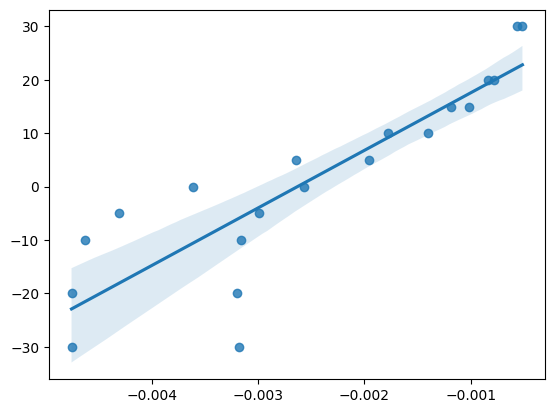

In [50]:
# Regression plot
sns.regplot(x=est_snr_arr, y=snr_arr)

**The lower SNR values (greater amount of noise, poorer audio quality) seem to be harder to predict!** (in this small sample)

In [51]:
# Evaluate model performance

truth = transcripts
performed = generated_text
asr_evaluation(truth, performed)

Model: 

Word Error Rate (WER) = 0.2875
Character Error Rate (CER) = 0.19244712990936555
Match Error Rate (MER) = 0.2782258064516129
Word Information Preserved (WIP) = 0.6282549019607844


In [52]:
# Model evaluation for each sentence
wer = []
cer = []
mer = []
wip = []

for i in range(len(truth)):
    wer.append(jiwer.wer(truth=truth[i], hypothesis=performed[i]))
    cer.append(jiwer.cer(truth=truth[i], hypothesis=performed[i]))
    mer.append(jiwer.mer(truth=truth[i], hypothesis=performed[i]))
    wip.append(jiwer.wip(truth=truth[i], hypothesis=performed[i]))

In [53]:
# Save sentence's scores to the dataframe
snr_df['wer'] = wer
snr_df['cer'] = cer
snr_df['mer'] = mer
snr_df['wip'] = wip
snr_df.to_csv('snr_experiment.csv', encoding='utf-8')

snr_df.head(20)

,signal,estimated_snr,snr,generated_text,transcripts,wer,cer,mer,wip
0,spk_id_10227_16144788259344_hallway_ch01snr0.wav,-0.003609,0,за рахунок бізнесу це звісно не подобає приємц...,за рахунок бізнесу звісно не подобається підпр...,0.151515,0.056769,0.147059,0.772268
1,spk_id_10227_16144788259344_hallway_ch01snr15.wav,-0.001189,15,за рахунок бізнесу це звісно не подобається пі...,за рахунок бізнесу звісно не подобається підпр...,0.121212,0.021834,0.114286,0.832035
2,spk_id_9558_16144787693268_hallway_ch01snr0.wav,-0.002571,0,більше двох десятків мешканців будинку прийшли...,більше двох десятків мешканців будинку прийшли...,0.000000,0.000000,0.000000,1.000000
3,spk_id_10227_16144788259344_hallway_ch01snr5.wav,-0.002641,5,за рахунок бізнесу це звісно не подобає ці при...,за рахунок бізнесу звісно не подобається підпр...,0.212121,0.052402,0.194444,0.728139
4,spk_id_9558_16144787693268_hallway_ch01snr5.wav,-0.001959,5,більше двох десятків мешканців будинку прийшли...,більше двох десятків мешканців будинку прийшли...,0.000000,0.000000,0.000000,1.000000
5,spk_id_10227_16144788259344_hallway_ch01snr-5.wav,-0.004311,-5,за рахунок бізнес це тісно не подобається приє...,за рахунок бізнесу звісно не подобається підпр...,0.181818,0.043668,0.176471,0.698752
6,spk_id_10227_16144788259344_hallway_ch01snr10.wav,-0.001777,10,за рахунок бізнесу це звісно не подобається пі...,за рахунок бізнесу звісно не подобається підпр...,0.121212,0.026201,0.114286,0.856506
7,spk_id_10227_16144788259344_hallway_ch01snr-10...,-0.004632,-10,за рахунок бізнес це віно недолікиємцям але ма...,за рахунок бізнесу звісно не подобається підпр...,0.272727,0.113537,0.264706,0.591856
8,spk_id_9558_16144787693268_hallway_ch01snr-5.wav,-0.002992,-5,більше двох десятків мешканців будинки прийшли...,більше двох десятків мешканців будинку прийшли...,0.066667,0.009804,0.066667,0.871111
9,spk_id_10227_16144788259344_hallway_ch01snr-20...,-0.004757,-20,а за рахунок місця чуті зараз титулів в і не н...,за рахунок бізнесу звісно не подобається підпр...,0.727273,0.467249,0.685714,0.146667


Text(0, 0.5, 'Performance Scores')

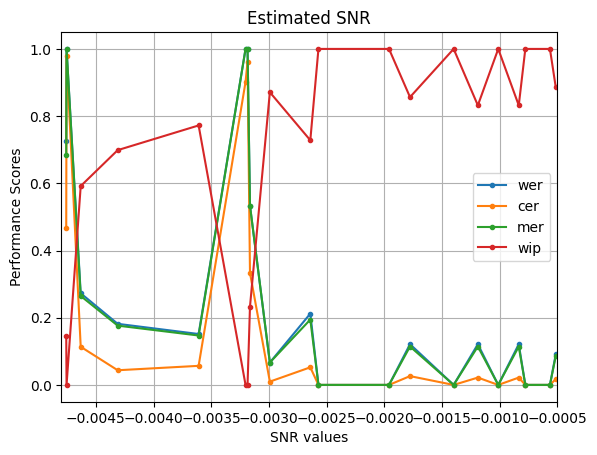

In [59]:
# Plot estimated SNR

import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

snr_df = snr_df.sort_values('estimated_snr', ascending = False)
ax = snr_df.plot(x='estimated_snr', y=['wer', 'cer', 'mer', 'wip'], grid=True, style='.-')
ax.set_xlim(-0.0048, -0.0005)
ax.xaxis.set_major_locator(MultipleLocator(0.0005))
plt.title("Estimated SNR")
plt.xlabel("SNR values")
plt.ylabel("Performance Scores")

Text(0, 0.5, 'Performance Scores')

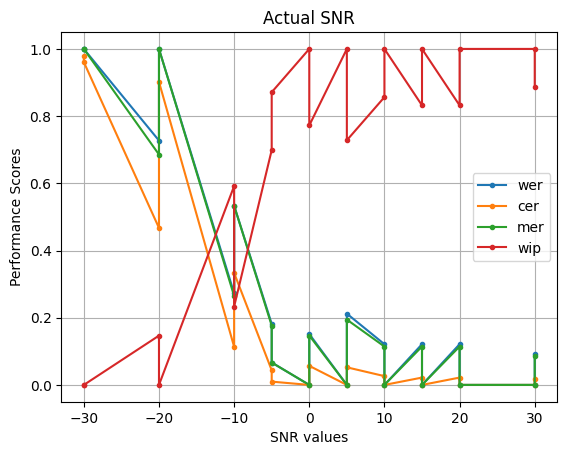

In [61]:
# Plot actual SNR

snr_df = snr_df.sort_values('snr', ascending = False)
ax = snr_df.plot(x='snr', y=['wer', 'cer', 'mer', 'wip'], grid=True, style='.-')
plt.title("Actual SNR")
plt.xlabel("SNR values")
plt.ylabel("Performance Scores")

Both plots show a similar trend, with a threshold after which the performance scores start getting somewhat acceptable. The threshold value is around -0.0026 for the estimated SNR values and 0 for the actual SNR values.